<a href="https://colab.research.google.com/github/sud0x00/SharadaProject-Annotated_Dataset/blob/main/DataVisualize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Visualization

### The following notebook contains code related to visualizing the data after extracting the images with labels from the annotations.

In [1]:
!git clone https://github.com/sud0x00/SharadaProject-Annotated_Dataset.git

Cloning into 'SharadaProject-Annotated_Dataset'...
remote: Enumerating objects: 438, done.
remote: Total 438 (delta 0), reused 0 (delta 0), pack-reused 438
Receiving objects: 100% (438/438), 371.36 MiB | 23.60 MiB/s, done.
Resolving deltas: 100% (32/32), done.
Updating files: 100% (497/497), done.


In [10]:
%mkdir dataset

In [11]:
from PIL import Image, ImageDraw, ImageOps
import json
import random
import string
import os
import numpy as np
import shutil

### The following code allows for the extraction images with labels from the annotations.

There are multiple conditions and exceptions which are added in the code due to the mislabelling present in the data

In [24]:
# Folder path containing the images and annotation files

src_folder = '/content/SharadaProject-Annotated_Dataset/Annotated Dataset/large-dataset'
dest_folder = '/content/dataset'

# Iterate over the files in the folder
for file_name in os.listdir(src_folder):
    # Check if the file is an image
    if file_name.endswith('.jpg') or file_name.endswith('.jpeg') or file_name.endswith('.png'):
        # Construct the full file paths for the image and annotation files
        image_file = os.path.join(src_folder, file_name)
        annotation_file = os.path.join(src_folder, f"{os.path.splitext(file_name)[0]}.json")
        # Load the annotation file
        with open(annotation_file, 'r', encoding='utf-8') as f:
            annotation = json.load(f)

        # Get the image dimensions
        image_height = annotation['imageHeight']
        image_width = annotation['imageWidth']

        # Open the original image
        image = Image.open(image_file)

        # Loop through each shape in the annotation
        for shape in annotation['shapes']:
            shape_type = shape['shape_type']
            group_id = shape['group_id']
            label = shape['label']
            coordinates = shape['points']


            # Check if label is equal to "||" and change it to ".."
            if label == '||':
                label = 'fs2'

            if label == '|':
                label = 'fs1'

            if label == '|| || ||':
                label = 'fs3'

            if label == '?':
                label = 'unk'

            if label == '.':
                label = 'period'

            if label == '^':
                label = 'oth1'

            if label == "-":
                label == 'oth3'

            # Generate a random string of length 15
            random_string = ''.join(random.choices(string.ascii_letters + string.digits, k=15))


            # Create a new image with a transparent background
            cropped_image = Image.new('RGBA', (image_width, image_height), (0, 0, 0, 0))

            # Create a draw object to draw the polygon on the new image
            draw = ImageDraw.Draw(cropped_image)

            # Convert the coordinates to integer tuples
            int_coordinates = [(int(point[0]), int(point[1])) for point in coordinates]

            # Draw the polygon on the new image
            draw.polygon(int_coordinates, fill=(255, 255, 255, 255))


            if shape_type == 'polygon':
                # Create a mask from the drawn polygon
                mask = ImageOps.invert(cropped_image.convert('L'))

                # Apply the mask to the original image
                masked_image = Image.new("RGBA", image.size)
                masked_image.paste(image, (0, 0), mask=cropped_image)

                # Find the bounding box of the polygon
                bbox = masked_image.getbbox()

                # Crop the masked image using the bounding box
                if bbox:
                    cropped_image = masked_image.crop(bbox)

                    # Create a new rectangular image with the determined background color
                    rectangular_image = Image.new("RGB", (cropped_image.width, cropped_image.height), (255, 255, 255))
                    rectangular_image.paste(cropped_image, (0, 0), cropped_image)

                    # Create the new filename with group ID, label, and random string
                    new_filename = os.path.join(dest_folder, f"{label}_{random_string}.jpg")

                    # Save the rectangular image as JPEG
                    rectangular_image.save(new_filename, format='JPEG', quality=100)

            if shape_type == 'rectangle':
                # Find the minimum and maximum x, y coordinates
                x_coordinates = [point[0] for point in int_coordinates]
                y_coordinates = [point[1] for point in int_coordinates]

                left = min(x_coordinates)
                top = min(y_coordinates)
                right = max(x_coordinates)
                bottom = max(y_coordinates)

                # Crop the original image using the bounding box
                cropped_image = image.crop((left, top, right, bottom))

                # Create the new filename with group ID, label, and random string
                new_filename = os.path.join(dest_folder, f"{label}_{random_string}.jpg")

                # Save the cropped image
                cropped_image.save(new_filename, format='JPEG', quality=100)

### Code which moves the extracted label images to it's respective directory

In [25]:
# Path to the folder containing the files
folder_path = '/content/dataset'

# Get a list of all files in the folder
files = os.listdir(folder_path)

# Iterate over each file
for file_name in files:
    if os.path.isfile(os.path.join(folder_path, file_name)):
        # Split the file name into label and random string
        label, random_string = file_name.split('_', 1)

        # Create the destination folder path
        destination_folder = os.path.join(folder_path, label)

        # Check if the destination folder exists, otherwise create it
        if not os.path.exists(destination_folder):
            os.makedirs(destination_folder)

        # Move the file to the destination folder
        shutil.move(os.path.join(folder_path, file_name), os.path.join(destination_folder, file_name))

print("Files moved successfully!")

Files moved successfully!


### Simple temporary code which is being used to convert the devenagari folder name to integer.

In [26]:
# Step 1: Read the names of all folders
folder_names = os.listdir("/content/dataset")  # Assuming the program is executed in the directory containing the folders

# Step 2: Create a dictionary with folder names and corresponding values
folder_dict = {}
for i, folder_name in enumerate(folder_names):
    folder_dict[folder_name] = i + 1000000000

# Step 3: Rename files inside folders
for folder_name, value in folder_dict.items():
    folder_path = os.path.join('/content/dataset', folder_name)
    files = os.listdir(folder_path)
    for file_name in files:
        if file_name.startswith(folder_name):
            new_file_name = f'{value}_{file_name.split("_", 1)[1]}'  # Extract the random string after the underscore
            old_file_path = os.path.join(folder_path, file_name)
            new_file_path = os.path.join(folder_path, new_file_name)
            os.rename(old_file_path, new_file_path)

# Step 4: Rename folders
for folder_name, value in folder_dict.items():
    old_folder_path = os.path.join('/content/dataset', folder_name)
    new_folder_path = os.path.join('/content/dataset', str(value))
    os.rename(old_folder_path, new_folder_path)

## Data Visualization code

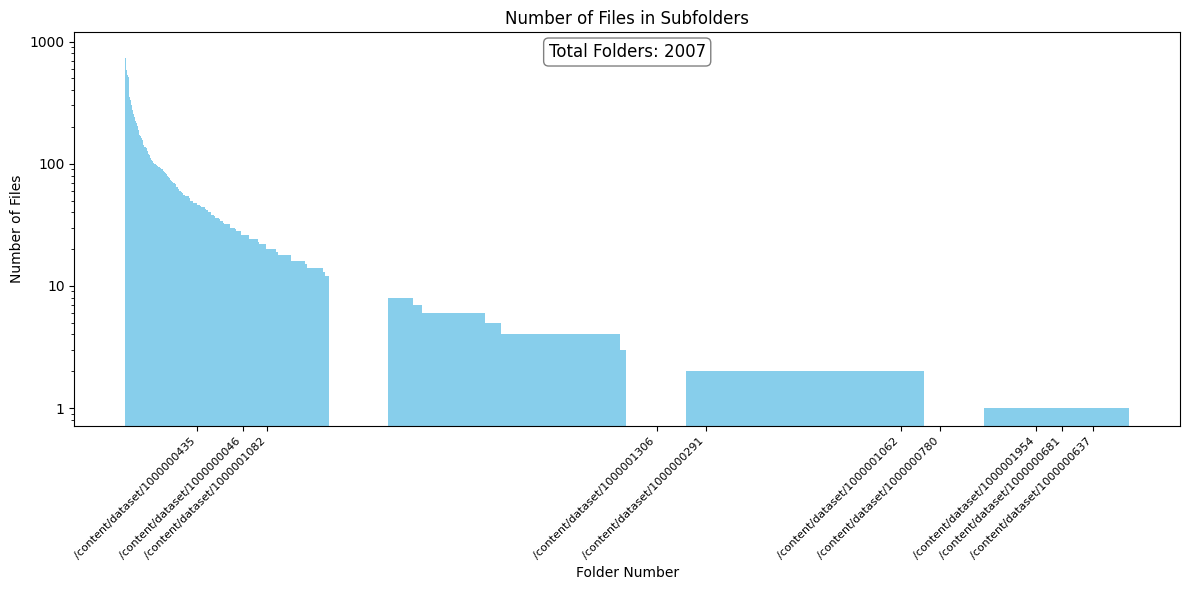

In [31]:
import os
import random
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

def count_files_in_subfolders(main_folder):
    subfolder_counts = {}
    for root, dirs, files in os.walk(main_folder):
        subfolder_counts[root] = len(files)
    return subfolder_counts

def visualize_subfolder_counts(subfolder_counts):
    sorted_subfolders = sorted(subfolder_counts.items(), key=lambda x: x[1], reverse=True)
    subfolders, file_counts = zip(*sorted_subfolders)

    num_subfolders = len(subfolders)
    indices = list(range(num_subfolders))

    plt.figure(figsize=(12, 6))
    plt.bar(indices, file_counts, color='skyblue')

    # Randomly select some labels to display on the x-axis
    num_labels_to_show = min(10, num_subfolders)  # Show a maximum of 10 labels (change as desired)
    random_indices = random.sample(indices, num_labels_to_show)
    plt.xticks(random_indices, [subfolders[i] for i in random_indices], rotation=45, ha='right', fontsize=8)

    plt.xlabel('Folder Number')
    plt.ylabel('Number of Files')
    plt.title('Number of Files in Subfolders')

    # Use a logarithmic scale for the y-axis to emphasize lower values
    plt.yscale('log')

    # Display total number of folders as text annotation
    plt.annotate(f'Total Folders: {num_subfolders}', xy=(0.5, 0.95), xycoords='axes fraction', fontsize=12,
                 ha='center', va='center', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray"))

    # Disable scientific notation for y-axis tick labels
    plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=False))

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main_folder = "/content/dataset"  # Replace with the actual path to your main folder
    subfolder_counts = count_files_in_subfolders(main_folder)
    visualize_subfolder_counts(subfolder_counts)
